In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm

import sys
sys.path.append('D:\diplom_2\my_test')
import my_funcs as mf

import my_thermal_funcs as mtf

## STENCIL-NET

##### 0. Mesh Params

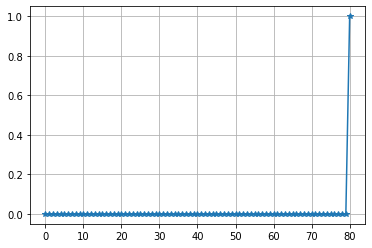

In [2]:
generate_flg=True # True - генерация, False - чтение уже сгенерированных
# generate_flg=False

n=81 #число узлов
L=1 # длина расчт области
T=.3 #конечное время
kurant=0.5

h=L/(n-1)
b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
# IC
v=[0 for i in range(0,n)]
# v=[np.sin(6.6*np.pi*i/n) for i in range(0,n)] #sin(6.6x)
# BC
v[0]=0
v[-1]=1

plt.plot(v,'-*')
plt.grid()

##### 1. Study params

In [3]:
main_params=pd.read_excel('init_params.xlsx')
main_params=main_params.set_index('param')
display(main_params)

#------------------------MAIN PARAMS-----------------------------
# size of filter to be applied
fs = int(main_params.loc['fs'])

# number of timesteps to be predicted during training 
m = int(main_params.loc['m'])

# decaying weights
decay_const = float(main_params.loc['decay_const'])

# epoch_number
epochs=int(main_params.loc['epochs'])

#random_seed
seed = int(main_params.loc['seed'])

#coef для loss функции
l_wd= float(main_params.loc['l_wd'])

# 'RK3' for runge-kutta solver and 'E1' for euler solver
method=str(main_params.loc['method'].values[0]) 

#neurons num in MLPConv
neurons=int(main_params.loc['neurons'])

#learning_rate
lr=float(main_params.loc['lr'])

#train_size
train_split=float(main_params.loc['train_split'])

# on/off bwd
has_backward=bool(main_params.loc['has_backward'].values[0])

#hidden_layers_num
hidden_layers_num=int(main_params.loc['hidden_layers_num'])

#device
device = mf.torch.device("cuda" if mf.torch.cuda.is_available() else "cpu")

#optuna n_trials
N_TRIALS=int(main_params.loc['N_TRIALS'])

,value
param,
seed,1
method,RK3
decay_const,0.9
train_split,0.5
m,4
epochs,100
l_wd,0.0
fs,2
neurons,64


##### 2.1 Generate data

In [4]:
CUSTOM_TAU=kurant*h**2#0.009
# CUSTOM_TAU=0.01
v_fact,x_lst,tau,time_lst=mtf.generate_data(generate_flg,v,T,L,0.5,h,n,CUSTOM_TAU=CUSTOM_TAU,save_flg=True)
print(v_fact.shape)

Генерация данных
3841 81
81 3841
(81, 3841)


##### 2.2 view dynamic of solution

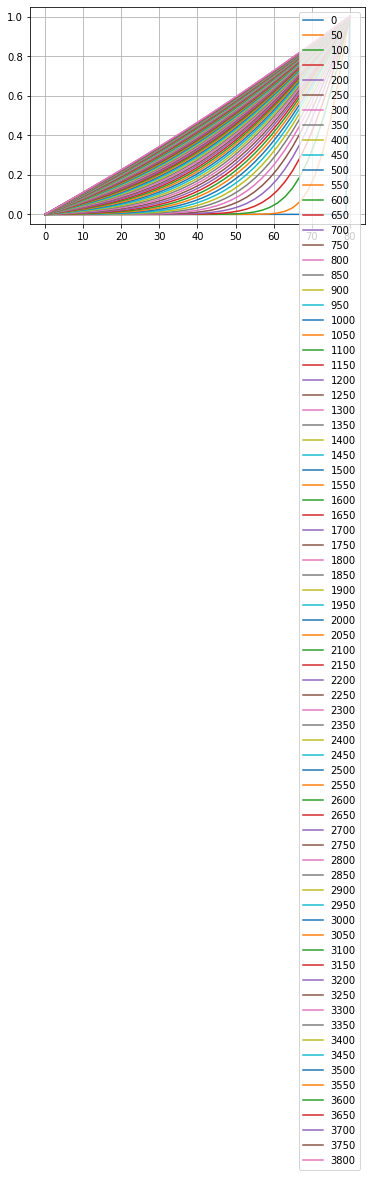

In [5]:
for j in range(0,len(v_fact[0,:]),50):
# for j in range(0,2,1):
    plt.plot(v_fact[:,j],label=str(j))
plt.legend()
plt.grid()

##### 3.Subsample Data

In [6]:
t_factor = 10  # time subsample factor 
s_factor = 4   # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=mf.subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

full_sample (21, 385)
train (21, 192)
test (21, 193)


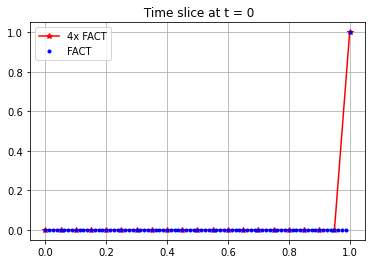

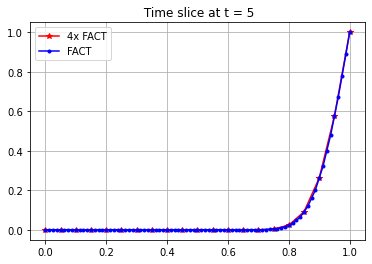

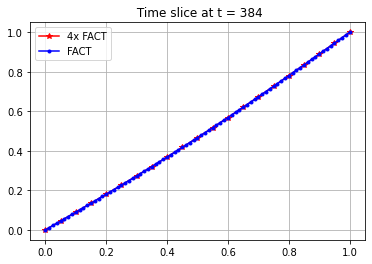

In [7]:
plt.figure()
time=0 #first time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*-',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t = 0")
plt.grid()
plt.show()

plt.figure()
time=5 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*-',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.-',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t = " + str(time))
plt.grid()
plt.show()

plt.figure()
time=v_coarse.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*-',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.-',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t = " + str(time))
plt.grid()
plt.show()


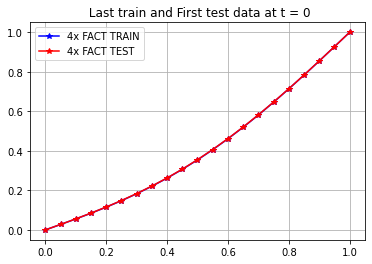

In [8]:
# Last train first test
plt.figure()
time=v_coarse_train.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse_train[:,time],'*-',color='blue',label=str(s_factor) + 'x FACT TRAIN')
time=0
plt.plot(x_lst[coarse_x],v_coarse_test[:,time],'*-',color='red',label=str(s_factor) + 'x FACT TEST')
plt.legend()
plt.title(" Last train and First test data at t = " + str(time))
plt.grid()
plt.show()

##### 4. Trainig model

In [9]:
import optuna

In [10]:
def objective_mplconv(trial):
    my_doc_params={
    'fs' : trial.suggest_categorical('fs',[1,2,3,4,5,6,7]#,8,9]),
    'neurons' : trial.suggest_categorical('neurons',[8,16,24,32,40,48,64]) ,
    'hidden_layers_num': trial.suggest_categorical('hidden_layers_num',[0,1,2,3,4]),
    'lr': trial.suggest_categorical('lr',[1e-02,1e-03]),
    'm' : trial.suggest_categorical('m',[2,4,6]) ,  
    'has_backward' : trial.suggest_categorical('has_backward',[True,False]),  
    'method' : trial.suggest_categorical('method',['RK3','E1']),
    'decay_const': trial.suggest_categorical('decay_const',[0.2,0.5,0.9])
    }
    
    ## loss на последней эпохе
    # metric=mf.train_net(mf.MLPConv,v_coarse_train,mf.epochs,dtc,
                        # **my_doc_params)[2]
    
    ## средние лосс с 10 последних итераций
    metric_lst=mf.train_net(mf.MLPConv,v_coarse_train,mf.epochs,dtc,
                        **my_doc_params)[1]
    
    metric_lst=np.array(metric_lst)[:,3][-10:]
    metric=np.mean(metric_lst)
    
    return metric

In [11]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_mplconv, n_trials=N_TRIALS)

[I 2024-11-06 16:03:01,094] A new study created in memory with name: no-name-b1e1df1d-baae-4aed-8384-ed4af55fa6f6


input 8 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7537


100%|█████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.66it/s, loss=0.000397]
[I 2024-11-06 16:03:41,229] Trial 0 finished with value: 0.0003988525422755629 and parameters: {'fs': 8, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 4, 'has_backward': False, 'method': 'RK3', 'decay_const': 0.9}. Best is trial 0 with value: 0.0003988525422755629.


input 3 output 16
input 16 output 16
input 16 output 1
#parameters: 353


100%|██████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.67it/s, loss=2.05e-5]
[I 2024-11-06 16:03:49,854] Trial 1 finished with value: 2.0521422447927763e-05 and parameters: {'fs': 3, 'neurons': 16, 'hidden_layers_num': 2, 'lr': 0.001, 'm': 4, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 1 with value: 2.0521422447927763e-05.


input 7 output 32
input 32 output 1
#parameters: 289


100%|██████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.22it/s, loss=1.28e-5]
[I 2024-11-06 16:03:54,430] Trial 2 finished with value: 1.2806187078240327e-05 and parameters: {'fs': 7, 'neurons': 32, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 4, 'has_backward': False, 'method': 'E1', 'decay_const': 0.2}. Best is trial 2 with value: 1.2806187078240327e-05.


input 1 output 24
input 24 output 24
input 24 output 24
input 24 output 1
#parameters: 1273


100%|█████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.48it/s, loss=0.000953]
[I 2024-11-06 16:04:03,189] Trial 3 finished with value: 0.0009544293396174907 and parameters: {'fs': 1, 'neurons': 24, 'hidden_layers_num': 3, 'lr': 0.001, 'm': 6, 'has_backward': False, 'method': 'E1', 'decay_const': 0.9}. Best is trial 2 with value: 1.2806187078240327e-05.


input 1 output 8
input 8 output 1
#parameters: 25


100%|███████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.31it/s, loss=8.8e-5]
[I 2024-11-06 16:04:07,174] Trial 4 finished with value: 8.818280839477666e-05 and parameters: {'fs': 1, 'neurons': 8, 'hidden_layers_num': 1, 'lr': 0.001, 'm': 2, 'has_backward': True, 'method': 'RK3', 'decay_const': 0.5}. Best is trial 2 with value: 1.2806187078240327e-05.


input 6 output 64
input 64 output 64
input 64 output 64
input 64 output 1
#parameters: 8833


100%|██████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.01it/s, loss=1.35e-5]
[I 2024-11-06 16:04:27,202] Trial 5 finished with value: 1.3499042233888759e-05 and parameters: {'fs': 6, 'neurons': 64, 'hidden_layers_num': 3, 'lr': 0.01, 'm': 6, 'has_backward': False, 'method': 'E1', 'decay_const': 0.2}. Best is trial 2 with value: 1.2806187078240327e-05.


input 1 output 40
input 40 output 40
input 40 output 1
#parameters: 1761


100%|███████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.66it/s, loss=8.6e-5]
[I 2024-11-06 16:04:42,264] Trial 6 finished with value: 8.603635360486806e-05 and parameters: {'fs': 1, 'neurons': 40, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 4, 'has_backward': False, 'method': 'RK3', 'decay_const': 0.5}. Best is trial 2 with value: 1.2806187078240327e-05.


input 1 output 1
#parameters: 2


100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.78it/s, loss=0.000467]
[I 2024-11-06 16:04:43,684] Trial 7 finished with value: 0.00046867478522472084 and parameters: {'fs': 1, 'neurons': 64, 'hidden_layers_num': 0, 'lr': 0.01, 'm': 4, 'has_backward': False, 'method': 'E1', 'decay_const': 0.9}. Best is trial 2 with value: 1.2806187078240327e-05.


input 4 output 16
input 16 output 1
#parameters: 97


100%|█████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.18it/s, loss=0.000101]
[I 2024-11-06 16:04:49,544] Trial 8 finished with value: 0.00010074575911858119 and parameters: {'fs': 4, 'neurons': 16, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 6, 'has_backward': False, 'method': 'E1', 'decay_const': 0.5}. Best is trial 2 with value: 1.2806187078240327e-05.


input 8 output 48
input 48 output 1
#parameters: 481


100%|██████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.50it/s, loss=1.31e-5]
[I 2024-11-06 16:04:55,649] Trial 9 finished with value: 1.3056514853815316e-05 and parameters: {'fs': 8, 'neurons': 48, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 4, 'has_backward': False, 'method': 'E1', 'decay_const': 0.2}. Best is trial 2 with value: 1.2806187078240327e-05.


input 7 output 1
#parameters: 8


100%|███████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.61it/s, loss=2.3e-5]
[I 2024-11-06 16:04:58,069] Trial 10 finished with value: 2.2987116972217335e-05 and parameters: {'fs': 7, 'neurons': 32, 'hidden_layers_num': 0, 'lr': 0.001, 'm': 2, 'has_backward': True, 'method': 'RK3', 'decay_const': 0.2}. Best is trial 2 with value: 1.2806187078240327e-05.


input 7 output 48
input 48 output 1
#parameters: 433


100%|██████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.32it/s, loss=1.28e-5]
[I 2024-11-06 16:05:03,031] Trial 11 finished with value: 1.280388014492928e-05 and parameters: {'fs': 7, 'neurons': 48, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 4, 'has_backward': False, 'method': 'E1', 'decay_const': 0.2}. Best is trial 11 with value: 1.280388014492928e-05.


input 7 output 32
input 32 output 1
#parameters: 289


100%|██████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.98it/s, loss=1.28e-5]
[I 2024-11-06 16:05:07,454] Trial 12 finished with value: 1.2806187078240327e-05 and parameters: {'fs': 7, 'neurons': 32, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 4, 'has_backward': False, 'method': 'E1', 'decay_const': 0.2}. Best is trial 11 with value: 1.280388014492928e-05.


input 7 output 32
input 32 output 1
#parameters: 289


100%|██████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.01it/s, loss=1.28e-5]
[I 2024-11-06 16:05:11,681] Trial 13 finished with value: 1.2806187078240327e-05 and parameters: {'fs': 7, 'neurons': 32, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 4, 'has_backward': False, 'method': 'E1', 'decay_const': 0.2}. Best is trial 11 with value: 1.280388014492928e-05.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s, loss=7.2e-6]
[I 2024-11-06 16:05:37,501] Trial 14 finished with value: 7.317314839383471e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 4, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s, loss=7.4e-6]
[I 2024-11-06 16:05:51,429] Trial 15 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.06it/s, loss=7.4e-6]
[I 2024-11-06 16:06:03,914] Trial 16 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.53it/s, loss=7.4e-6]
[I 2024-11-06 16:06:17,269] Trial 17 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 2 output 40
input 40 output 40
input 40 output 40
input 40 output 40
input 40 output 1
#parameters: 5081


100%|██████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s, loss=8.22e-5]
[I 2024-11-06 16:06:47,004] Trial 18 finished with value: 8.284160139737651e-05 and parameters: {'fs': 2, 'neurons': 40, 'hidden_layers_num': 4, 'lr': 0.001, 'm': 2, 'has_backward': True, 'method': 'RK3', 'decay_const': 0.5}. Best is trial 14 with value: 7.317314839383471e-06.


input 5 output 24
input 24 output 24
input 24 output 24
input 24 output 24
input 24 output 1
#parameters: 1969


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.63it/s, loss=2.25e-5]
[I 2024-11-06 16:06:58,669] Trial 19 finished with value: 2.276568775414489e-05 and parameters: {'fs': 5, 'neurons': 24, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.9}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 8
input 8 output 8
input 8 output 8
input 8 output 8
input 8 output 1
#parameters: 305


100%|███████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.08it/s, loss=8.5e-6]
[I 2024-11-06 16:07:05,388] Trial 20 finished with value: 9.288416640629293e-06 and parameters: {'fs': 9, 'neurons': 8, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.03it/s, loss=7.4e-6]
[I 2024-11-06 16:07:19,691] Trial 21 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s, loss=7.4e-6]
[I 2024-11-06 16:07:33,767] Trial 22 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s, loss=7.4e-6]
[I 2024-11-06 16:07:47,515] Trial 23 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.50it/s, loss=7.4e-6]
[I 2024-11-06 16:08:00,934] Trial 24 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.70it/s, loss=7.3e-6]
[I 2024-11-06 16:08:38,103] Trial 25 finished with value: 7.389465827145613e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 2 output 1
#parameters: 3


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.92it/s, loss=2.03e-5]
[I 2024-11-06 16:08:49,353] Trial 26 finished with value: 2.0311877233325503e-05 and parameters: {'fs': 2, 'neurons': 48, 'hidden_layers_num': 0, 'lr': 0.001, 'm': 6, 'has_backward': True, 'method': 'RK3', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 4 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7345


100%|██████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s, loss=1.45e-5]
[I 2024-11-06 16:09:24,045] Trial 27 finished with value: 1.5243062443914824e-05 and parameters: {'fs': 4, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 5 output 16
input 16 output 16
input 16 output 16
input 16 output 1
#parameters: 657


100%|██████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s, loss=2.61e-5]
[I 2024-11-06 16:09:42,780] Trial 28 finished with value: 2.848764070222387e-05 and parameters: {'fs': 5, 'neurons': 16, 'hidden_layers_num': 3, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.5}. Best is trial 14 with value: 7.317314839383471e-06.


input 3 output 48
input 48 output 48
input 48 output 1
#parameters: 2593


100%|█████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s, loss=0.000163]
[I 2024-11-06 16:10:39,373] Trial 29 finished with value: 0.0001774480100721121 and parameters: {'fs': 3, 'neurons': 48, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'RK3', 'decay_const': 0.9}. Best is trial 14 with value: 7.317314839383471e-06.


input 8 output 8
input 8 output 8
input 8 output 8
input 8 output 8
input 8 output 1
#parameters: 297


100%|██████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s, loss=0.00141]
[I 2024-11-06 16:11:06,064] Trial 30 finished with value: 0.0014169431757181882 and parameters: {'fs': 8, 'neurons': 8, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.9}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.43it/s, loss=7.4e-6]
[I 2024-11-06 16:11:19,601] Trial 31 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.49it/s, loss=7.4e-6]
[I 2024-11-06 16:11:33,027] Trial 32 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s, loss=7.2e-6]
[I 2024-11-06 16:11:57,669] Trial 33 finished with value: 7.317314839383471e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 4, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 6 output 24
input 24 output 24
input 24 output 24
input 24 output 24
input 24 output 1
#parameters: 1993


100%|██████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s, loss=2.31e-5]
[I 2024-11-06 16:12:17,044] Trial 34 finished with value: 2.3261447677214164e-05 and parameters: {'fs': 6, 'neurons': 24, 'hidden_layers_num': 4, 'lr': 0.001, 'm': 4, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|██████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.53it/s, loss=1.68e-5]
[I 2024-11-06 16:12:35,217] Trial 35 finished with value: 1.6952930673141962e-05 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 4, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 40
input 40 output 40
input 40 output 40
input 40 output 1
#parameters: 3721


100%|███████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s, loss=9.4e-6]
[I 2024-11-06 16:12:52,194] Trial 36 finished with value: 9.575334752298659e-06 and parameters: {'fs': 9, 'neurons': 40, 'hidden_layers_num': 3, 'lr': 0.01, 'm': 4, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 3 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7297


100%|██████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s, loss=2.51e-5]
[I 2024-11-06 16:13:15,338] Trial 37 finished with value: 2.532546659494983e-05 and parameters: {'fs': 3, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.001, 'm': 4, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 16
input 16 output 16
input 16 output 16
input 16 output 16
input 16 output 1
#parameters: 993


100%|██████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s, loss=1.47e-5]
[I 2024-11-06 16:14:05,659] Trial 38 finished with value: 1.5085466020536843e-05 and parameters: {'fs': 9, 'neurons': 16, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 4, 'has_backward': True, 'method': 'RK3', 'decay_const': 0.5}. Best is trial 14 with value: 7.317314839383471e-06.


input 6 output 1
#parameters: 7


100%|██████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.49it/s, loss=0.00175]
[I 2024-11-06 16:14:10,865] Trial 39 finished with value: 0.0017600514111109078 and parameters: {'fs': 6, 'neurons': 48, 'hidden_layers_num': 0, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.9}. Best is trial 14 with value: 7.317314839383471e-06.


input 4 output 64
input 64 output 64
input 64 output 1
#parameters: 4545


100%|██████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.67it/s, loss=1.82e-5]
[I 2024-11-06 16:14:28,587] Trial 40 finished with value: 1.8201713464804926e-05 and parameters: {'fs': 4, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 4, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.28it/s, loss=7.4e-6]
[I 2024-11-06 16:14:42,414] Trial 41 finished with value: 7.50593280827161e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.75it/s, loss=7.3e-6]
[I 2024-11-06 16:15:18,913] Trial 42 finished with value: 7.389465827145613e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7585


100%|███████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.68it/s, loss=7.3e-6]
[I 2024-11-06 16:15:56,304] Trial 43 finished with value: 7.389465827145613e-06 and parameters: {'fs': 9, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 1 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 4849


100%|██████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s, loss=1.73e-5]
[I 2024-11-06 16:16:28,072] Trial 44 finished with value: 1.734984944050666e-05 and parameters: {'fs': 1, 'neurons': 48, 'hidden_layers_num': 3, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 8 output 24
input 24 output 24
input 24 output 24
input 24 output 24
input 24 output 1
#parameters: 2041


100%|███████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s, loss=1.7e-5]
[I 2024-11-06 16:16:56,508] Trial 45 finished with value: 1.7002366985252592e-05 and parameters: {'fs': 8, 'neurons': 24, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 8
input 8 output 8
input 8 output 8
input 8 output 8
input 8 output 1
#parameters: 305


100%|██████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.95it/s, loss=1.56e-5]
[I 2024-11-06 16:17:16,809] Trial 46 finished with value: 1.5669507047277875e-05 and parameters: {'fs': 9, 'neurons': 8, 'hidden_layers_num': 4, 'lr': 0.001, 'm': 6, 'has_backward': False, 'method': 'RK3', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 9 output 32
input 32 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 3521


100%|███████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s, loss=7.5e-6]
[I 2024-11-06 16:17:46,529] Trial 47 finished with value: 7.931499521873774e-06 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.2}. Best is trial 14 with value: 7.317314839383471e-06.


input 2 output 1
#parameters: 3


100%|█████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.99it/s, loss=0.000165]
[I 2024-11-06 16:17:50,460] Trial 48 finished with value: 0.00016534713213331998 and parameters: {'fs': 2, 'neurons': 40, 'hidden_layers_num': 0, 'lr': 0.01, 'm': 6, 'has_backward': True, 'method': 'E1', 'decay_const': 0.5}. Best is trial 14 with value: 7.317314839383471e-06.


input 5 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7393


100%|███████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s, loss=7.1e-6]
[I 2024-11-06 16:18:09,863] Trial 49 finished with value: 7.2333403750235444e-06 and parameters: {'fs': 5, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': False, 'method': 'E1', 'decay_const': 0.2}. Best is trial 49 with value: 7.2333403750235444e-06.


In [12]:
study.trials_dataframe()
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'fs': 5, 'neurons': 48, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 6, 'has_backward': False, 'method': 'E1', 'decay_const': 0.2}
Best RMSE: 7.2333403750235444e-06


In [13]:
my_doc_params=study.best_params
net,loss_lst,loss=mf.train_net(mf.MLPConv,v_coarse_train,mf.epochs,dtc,
                               **my_doc_params)

input 5 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7393


100%|███████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s, loss=7.1e-6]


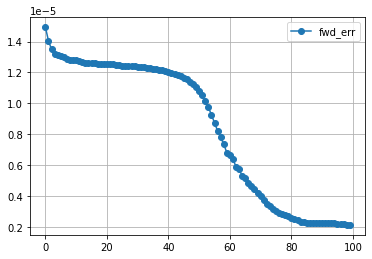

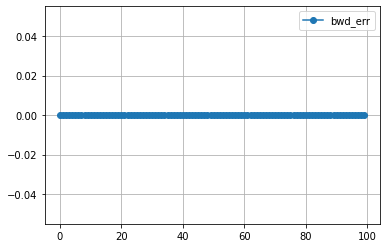

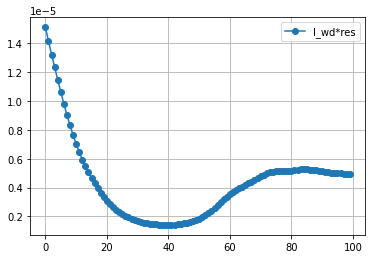

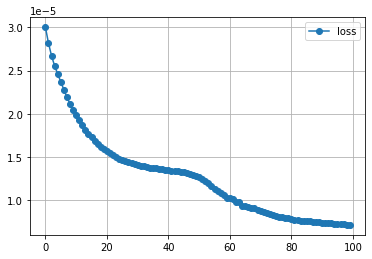

In [14]:
mf.plot_err_and_components_of_err(np.array(loss_lst))

##### 4/2. Re-fit on higher epoch_num 

In [15]:
high_epochs=1000
my_doc_params=study.best_params
my_doc_params.update({'epoch':high_epochs})
display(mf.make_param_table(net,my_doc_params,tau,h,n,t_factor,s_factor))

,Parameter,Value
0,fs,5
1,neurons,48
2,hidden_layers_num,4
3,act_func,ELU(alpha=1.0)
4,epoch,1000
5,lr,0.01
6,tau,0.000078
7,h,0.0125
8,n,81
9,decay_const,0.2


In [16]:
mf.make_param_table(net,my_doc_params,tau,h,n,t_factor,s_factor).to_excel('data/models/all_best_params_n='+str(n)+'_'+str(list(my_doc_params.values()))+'.xlsx',index=False)

In [17]:
my_doc_params

{'fs': 5,
 'neurons': 48,
 'hidden_layers_num': 4,
 'lr': 0.01,
 'm': 6,
 'has_backward': False,
 'method': 'E1',
 'decay_const': 0.2,
 'epoch': 1000}

In [18]:
del my_doc_params['epoch']
net,loss_lst,loss=mf.train_net(mf.MLPConv,v_coarse_train,high_epochs,dtc,**my_doc_params)

input 5 output 48
input 48 output 48
input 48 output 48
input 48 output 48
input 48 output 1
#parameters: 7393


100%|█████████████████████████████████████████████████| 1000/1000 [02:58<00:00,  5.61it/s, loss=6.1e-6]


##### 5. save_model

In [19]:
# str(list(my_doc_params))

In [20]:
my_doc_params.values()

dict_values([5, 48, 4, 0.01, 6, False, 'E1', 0.2])

In [21]:
# save model
import torch
torch.save(net, './data/models/model_thermal_n=' +str(n)+'_'+ str(list(my_doc_params.values())) +fr'_seed_'+ str(seed)  + '.pth')

In [22]:
# save study history
study.trials_dataframe().to_excel(fr'data/models/trials_dataframe_n=' +str(n)+'_'+ str(list(my_doc_params.values()))+'.xlsx',index=False)

In [23]:
# save hyperparams
my_doc_params['fs']=[my_doc_params['fs']]
pd.DataFrame.from_dict(my_doc_params,dtype=str)

,fs,neurons,hidden_layers_num,lr,m,has_backward,method,decay_const
0,5,48,4,0.01,6,False,E1,0.2


In [24]:
pd.DataFrame.from_dict(my_doc_params,dtype=str).to_excel(fr'data/models/best_params_n=' +str(n)+'_'+str(list(my_doc_params.values()))+'.xlsx',index=False)

##### 6. load_model

In [25]:
# neurons = 64
# fs=7
# epochs=100
# m=4
# l_wd=0#1e-3
# seed=1
#method='E1'

# net = load_simulation_model(s_factor, t_factor, neurons, device)

# net=torch.load('./models/model_thermal_n=' +str(n)+'_' + str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

##### 7. Simulation

In [26]:
NN_sim,T_sim,x_sim=mf.make_simulation(net,v_coarse,L,Lxc,dtc)

RK3


100%|███████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 387.91it/s]


##### 8. view_results

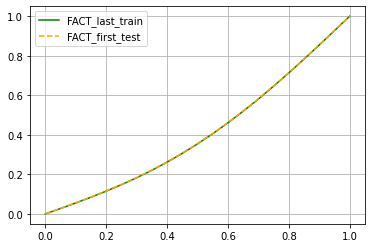

In [27]:
mf.view_train_test_graph(x_sim,v_coarse_train,v_coarse_test)

In [28]:
# todo
my_doc_params.update({'epoch':high_epochs})
display(mf.make_param_table(net,my_doc_params,tau,h,n,t_factor,s_factor))

,Parameter,Value
0,fs,[5]
1,neurons,48
2,hidden_layers_num,4
3,act_func,ELU(alpha=1.0)
4,epoch,1000
5,lr,0.01
6,tau,0.000078
7,h,0.0125
8,n,81
9,decay_const,0.2


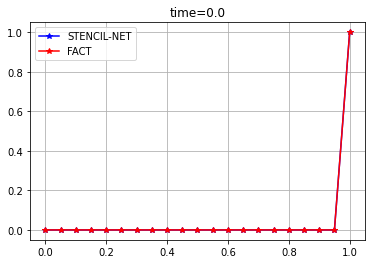

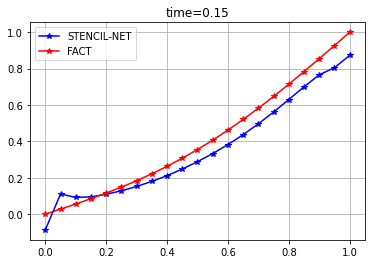

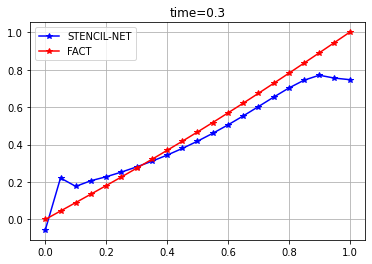

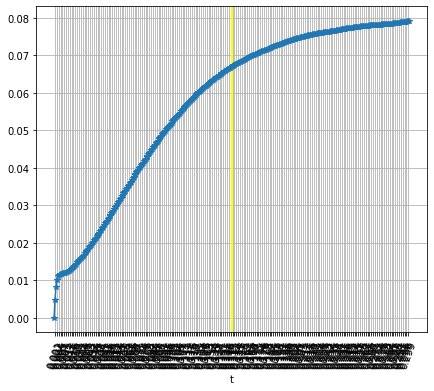

In [29]:
mf.view_results(T_sim,x_sim,NN_sim,v_coarse,T,dtc,n=3)

# mf.view_result_imshow(NN_sim,v_coarse,T,dtc,L,dxc)

mf.view_result_metric(NN_sim,v_coarse,T,dtc,L,dxc)

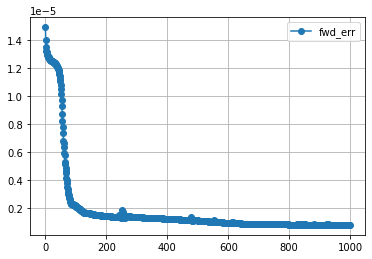

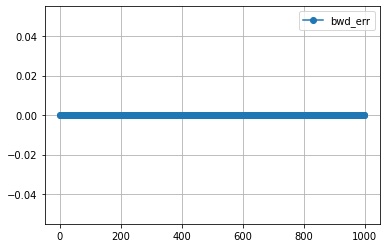

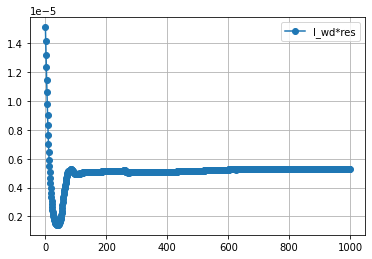

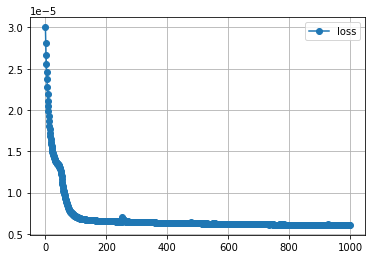

In [30]:
mf.plot_err_and_components_of_err(np.array(loss_lst))